tensor([[-0.4773, -0.0692],
        [-0.0410, -0.8667],
        [-0.2327,  0.3490],
        [-0.0442, -0.7437]])
[[-10. -10.]
 [ 10.  10.]
 [-10.  10.]
 [ 10. -10.]]


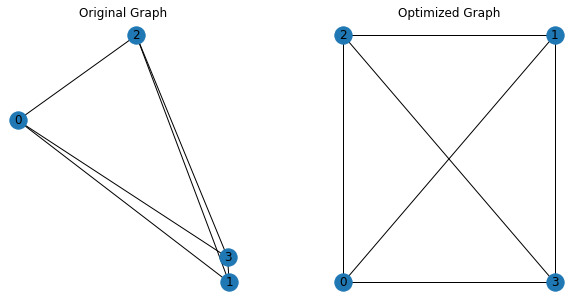

In [3]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
import scipy.sparse as sp
from collections.abc import Iterable
import networkx as nx
import numpy as np
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

# Define the adjacency matrix and node features
adj_matrix = sp.coo_matrix([[0, 1, 1, 1],
                            [1, 0, 1, 1],
                            [1, 1, 0, 1],
                            [1, 1, 1, 0]], dtype=np.float32)
node_features = torch.tensor(np.random.uniform(low=-1, high=1, size=(4, 2)), dtype=torch.float)

# Convert the graph to a PyTorch Geometric data object
edge_index, edge_weight = from_scipy_sparse_matrix(adj_matrix)
data = Data(x=torch.FloatTensor(node_features), edge_index=edge_index, edge_attr=torch.FloatTensor(edge_weight))

# Define the GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.fc1 = torch.nn.Linear(2, 16)
        self.fc2 = torch.nn.Linear(16, 8)
        self.fc3 = torch.nn.Linear(8, 4)
        self.fc4 = torch.nn.Linear(4, 2)
        self.relu = torch.nn.ReLU()
       
    def forward(self, data):
        x = data.x
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        # Clip node positions to a box between (-10, -10) and (10, 10)
        x = torch.clamp(x, -10.0, 10.0)
        return x

# Define the pairwise distance loss function
def pairwise_distance_loss(x):
    n = x.shape[0]
    dists = torch.cdist(x, x, p=2)  # Pairwise distances
    loss = -torch.sum(dists) / (n*(n-1))  # Minimize sum of distances
    for i in range(n):
        for j in range(i+1, n):
            # Add a repulsive force between nodes that are too close
            d = torch.dist(x[i], x[j], p=2)
            if d < 4.5:
                loss += 1.0 - d
    return loss

# Train the GNN model
model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(5000):
    optimizer.zero_grad()
    output = model(data)
    loss = pairwise_distance_loss(output)
    loss.backward()
    optimizer.step()

# Predict the new node positions
new_node_features = model(data).detach().numpy()

# Plot the original and optimized graphs
G = nx.Graph(adj_matrix.toarray())
pos = {i: node_features[i].numpy() for i in range(adj_matrix.shape[0])}
new_pos = {i: new_node_features[i] for i in range(adj_matrix.shape[0])}

print(node_features)
print(new_node_features)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('Original Graph')
nx.draw(G, pos=pos, ax=ax1, with_labels=True)
ax2.set_title('Optimized Graph')
nx.draw(G, pos=new_pos, ax=ax2, with_labels=True)
plt.subplots_adjust(wspace=0.4)
plt.show()